In [25]:

import pandas as pd

df = pd.read_csv("sandwich.csv")
df.head()


,antCount,bread,topping,butter
0,34,Rye,Ham and gherkins,no
1,47,Multi Grain,Peanut butter,yes
2,67,White,Ham and gherkins,yes
3,63,Multi Grain,Ham and gherkins,yes
4,65,Rye,Ham and gherkins,no


In [27]:

print(df.info())
print("\nMissing values:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   antCount  48 non-null     int64 
 1   bread     48 non-null     object
 2   topping   48 non-null     object
 3   butter    48 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.6+ KB
None

Missing values:
 antCount    0
bread       0
topping     0
butter      0
dtype: int64


In [29]:

df.columns = ['antCount', 'bread', 'topping', 'butter']

In [31]:

df['bread'] = df['bread'].astype('category')
df['topping'] = df['topping'].astype('category')
df['butter'] = df['butter'].astype('category')

In [33]:

print("\nCategories:\n")
print("Bread:", df['bread'].unique())
print("Topping:", df['topping'].unique())
print("Butter:", df['butter'].unique())


Categories:

Bread: ['Rye', 'Multi Grain', 'White', 'Whole Grain']
Categories (4, object): ['Multi Grain', 'Rye', 'White', 'Whole Grain']
Topping: ['Ham and gherkins', 'Peanut butter', 'Yeast spread']
Categories (3, object): ['Ham and gherkins', 'Peanut butter', 'Yeast spread']
Butter: ['no', 'yes']
Categories (2, object): ['no', 'yes']



Overall Ant Count Description:
 count    48.000000
mean     43.500000
std      15.148906
min      18.000000
25%      30.500000
50%      43.000000
75%      57.000000
max      76.000000
Name: antCount, dtype: float64

Grouped Descriptive Statistics:
                                      mean        std  min  max
bread       topping          butter                           
Multi Grain Ham and gherkins no      47.5  16.263456   36   59
                             yes     69.5   9.192388   63   76
            Peanut butter    no      20.5   2.121320   19   22
                             yes     53.5   9.192388   47   60
            Yeast spread     no      40.0   2.828427   38   42
                             yes     27.0   1.414214   26   28
Rye         Ham and gherkins no      49.5  21.920310   34   65
                             yes     49.5  12.020815   41   58
            Peanut butter    no      53.0   8.485281   47   59
                             yes     39.0   4.242641   36

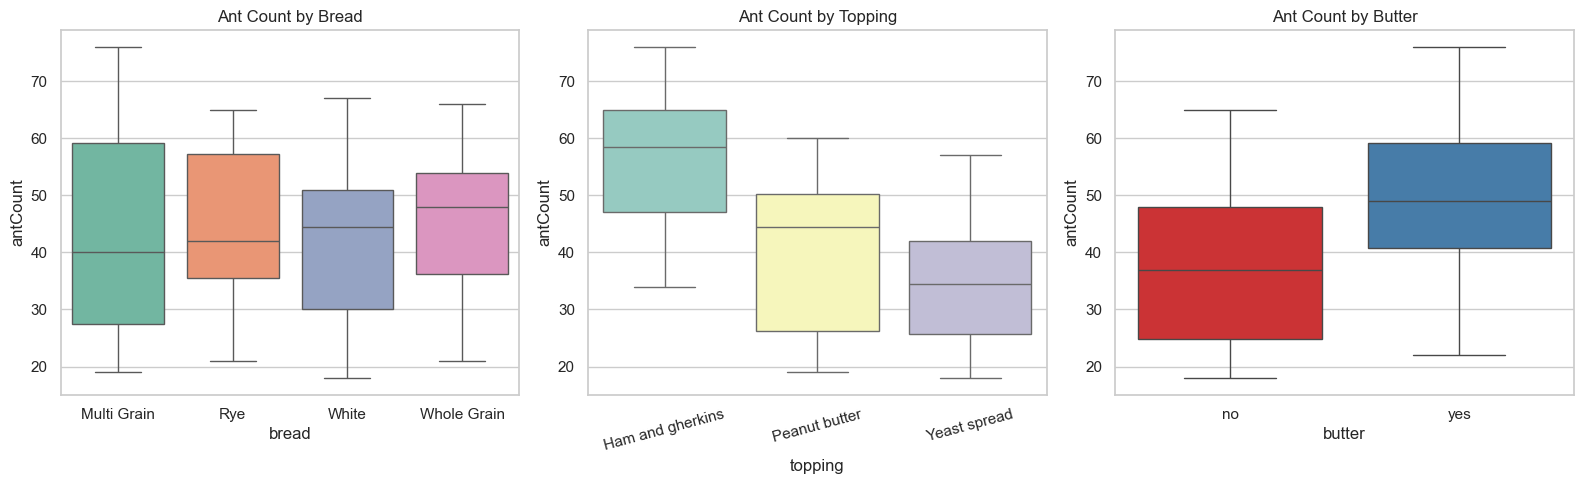

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


print("\nOverall Ant Count Description:\n", df['antCount'].describe())


group_stats = df.groupby(['bread', 'topping', 'butter'], observed=False)['antCount'].agg(['mean', 'std', 'min', 'max'])
print("\nGrouped Descriptive Statistics:\n", group_stats)


sns.set(style="whitegrid")
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=df, x='bread', y='antCount', hue='bread', palette='Set2', legend=False)
plt.title("Ant Count by Bread")

plt.subplot(1, 3, 2)
sns.boxplot(data=df, x='topping', y='antCount', hue='topping', palette='Set3', legend=False)
plt.title("Ant Count by Topping")
plt.xticks(rotation=15)

plt.subplot(1, 3, 3)
sns.boxplot(data=df, x='butter', y='antCount', hue='butter', palette='Set1', legend=False)
plt.title("Ant Count by Butter")

plt.tight_layout()
plt.show()


In [37]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import shapiro, levene
import numpy as np
import warnings


model = ols('antCount ~ C(bread) * C(topping) * C(butter)', data=df).fit()




print("\nShapiro-Wilk Test (Normality):", shapiro(model.resid))


grouped = []
skipped = 0

for name, group in df.groupby(['bread', 'topping', 'butter'], observed=False):
    values = group["antCount"].values
    if len(values) > 1 and np.var(values, ddof=1) > 0:
        grouped.append(values)
    else:
        skipped += 1


with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    if len(grouped) >= 2:
        levene_result = levene(*grouped)
        print(f"\nLevene’s Test (Homogeneity): using {len(grouped)} groups, skipped {skipped}")
        print(levene_result)
    else:
        print(f"\nLevene’s Test: Not enough valid groups (only {len(grouped)} usable, {skipped} skipped).")


anova_table = sm.stats.anova_lm(model, typ=2)
print("\nClassical ANOVA Table (Type II):\n", anova_table)



Shapiro-Wilk Test (Normality): ShapiroResult(statistic=0.9895522169947445, pvalue=0.9429503024464372)

Levene’s Test (Homogeneity): using 24 groups, skipped 0
LeveneResult(statistic=inf, pvalue=0.0)

Classical ANOVA Table (Type II):
                                 sum_sq    df          F    PR(>F)
C(bread)                         40.50   3.0   0.142043  0.933761
C(topping)                     3720.50   2.0  19.572994  0.000009
C(butter)                      1386.75   1.0  14.590969  0.000830
C(bread):C(topping)             577.00   6.0   1.011837  0.440987
C(bread):C(butter)              378.75   3.0   1.328365  0.288413
C(topping):C(butter)             56.00   2.0   0.294608  0.747479
C(bread):C(topping):C(butter)  2345.50   6.0   4.113108  0.005597
Residual                       2281.00  24.0        NaN       NaN


In [39]:
import pingouin as pg

aov_pg = pg.anova(dv='antCount', between=['bread', 'topping', 'butter'], data=df, detailed=True)


base_cols = ['Source', 'F', 'p-unc']
effect_cols = ['np2', 'eta2', 'etasq', 'omega']
available_cols = base_cols + [col for col in effect_cols if col in aov_pg.columns]


print("\nANOVA Table with Available Effect Sizes:\n", aov_pg[available_cols])



ANOVA Table with Available Effect Sizes:
                      Source          F     p-unc       np2
0                     bread   0.142043  0.933761  0.017446
1                   topping  19.572994  0.000009  0.619928
2                    butter  14.590969  0.000830  0.378093
3           bread * topping   1.011837  0.440987  0.201889
4            bread * butter   1.328365  0.288413  0.142401
5          topping * butter   0.294608  0.747479  0.023962
6  bread * topping * butter   4.113108  0.005597  0.506971
7                  Residual        NaN       NaN       NaN


In [41]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


full_model = ols('antCount ~ C(bread) * C(topping) * C(butter)', data=df).fit()


reduced_model = ols('antCount ~ C(bread) + C(topping) + C(butter)', data=df).fit()


bic_full = full_model.bic
bic_reduced = reduced_model.bic
bic_diff = bic_reduced - bic_full

print("\nBayesian-style Model Comparison using BIC:")
print(f"  Full Model BIC       = {bic_full:.2f}")
print(f"  Reduced Model BIC    = {bic_reduced:.2f}")
print(f"  ΔBIC = {bic_diff:.2f} → ", end="")

if bic_diff > 10:
    print("Strong evidence for including interactions.")
elif 6 < bic_diff <= 10:
    print("Moderate evidence for including interactions.")
elif 2 < bic_diff <= 6:
    print("Weak evidence for including interactions.")
else:
    print("No meaningful evidence to prefer full model.")



Bayesian-style Model Comparison using BIC:
  Full Model BIC       = 414.46
  Reduced Model BIC    = 392.09
  ΔBIC = -22.37 → No meaningful evidence to prefer full model.



Tukey HSD - Bread:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower    upper  reject
---------------------------------------------------------------
Multi Grain         Rye     1.25 0.9973 -15.7843 18.2843  False
Multi Grain       White    -0.75 0.9994 -17.7843 16.2843  False
Multi Grain Whole Grain      1.5 0.9954 -15.5343 18.5343  False
        Rye       White     -2.0 0.9892 -19.0343 15.0343  False
        Rye Whole Grain     0.25    1.0 -16.7843 17.2843  False
      White Whole Grain     2.25 0.9848 -14.7843 19.2843  False
---------------------------------------------------------------

Tukey HSD - Topping:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2    meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Ham and gherkins Peanut butter  -15.125 0.0038 -25.862  -4.388   True
Ham and gherkins  Yeast spread  -20.87

<Figure size 640x480 with 0 Axes>

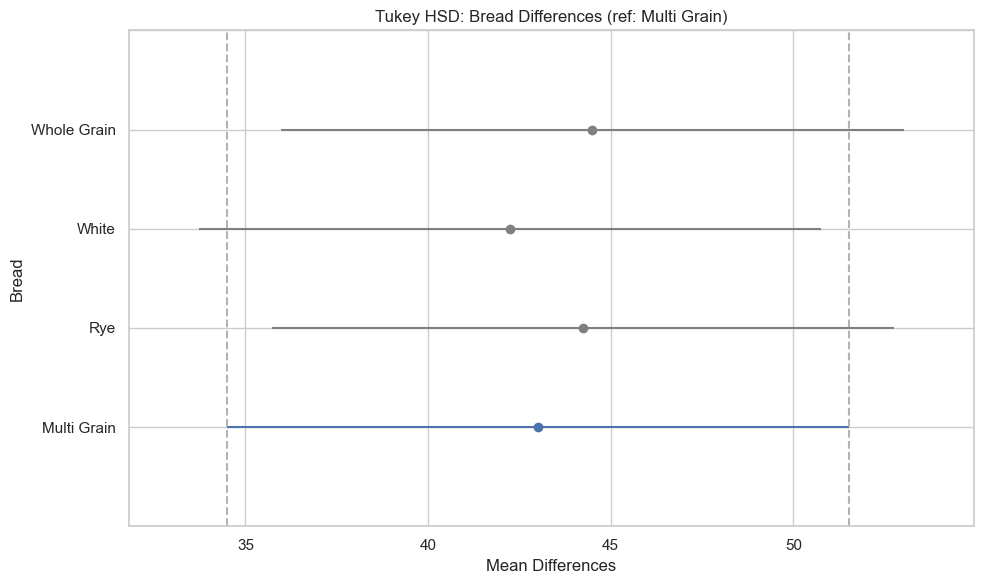

<Figure size 640x480 with 0 Axes>

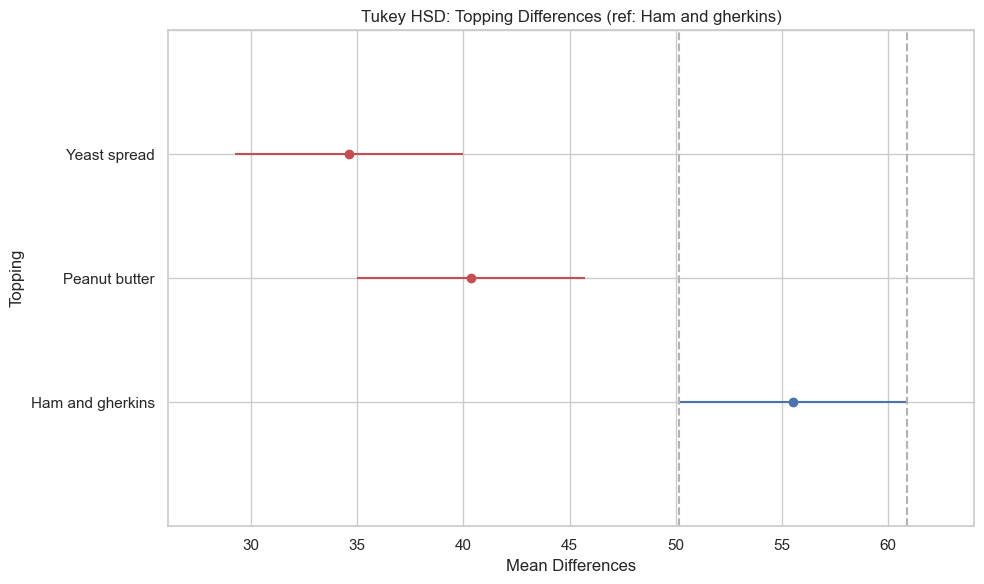

In [43]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

print("\nTukey HSD - Bread:")
tukey_bread = pairwise_tukeyhsd(endog=df['antCount'], groups=df['bread'], alpha=0.05)
print(tukey_bread)


print("\nTukey HSD - Topping:")
tukey_topping = pairwise_tukeyhsd(endog=df['antCount'], groups=df['topping'], alpha=0.05)
print(tukey_topping)


bread_groups = tukey_bread.groupsunique
topping_groups = tukey_topping.groupsunique


def safe_plot(tukey_result, group_list, title, ylabel):
    plt.figure()
    for group in group_list:
        try:
            tukey_result.plot_simultaneous(comparison_name=group,
                                           xlabel='Mean Differences',
                                           ylabel=ylabel)
            plt.title(f"Tukey HSD: {title} (ref: {group})")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            return  # Stop after the first successful plot
        except Exception as e:
            print(f"Skipping group '{group}': {e}")

    
    print("Fallback: plotting without reference group")
    plt.figure()
    tukey_result.plot_simultaneous()
    plt.title(f"Tukey HSD: {title} (no ref group)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


safe_plot(tukey_bread, bread_groups, "Bread Differences", "Bread")
safe_plot(tukey_topping, topping_groups, "Topping Differences", "Topping")


In [45]:
import numpy as np
from scipy.stats import ttest_ind

def hedges_g(x, y):
    """Compute Hedges' g effect size"""
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    g = (np.mean(x) - np.mean(y)) / pooled_std
    correction = 1 - (3 / (4 * dof - 1))  
    return g * correction

from itertools import combinations

print("\nHedges' g for Bread Pairs:")
for grp1, grp2 in combinations(df['bread'].unique(), 2):
    x = df[df['bread'] == grp1]['antCount']
    y = df[df['bread'] == grp2]['antCount']
    g = hedges_g(x, y)
    print(f"{grp1} vs {grp2}: Hedges' g = {g:.3f}")


print("\nHedges' g for Topping Pairs:")
for grp1, grp2 in combinations(df['topping'].unique(), 2):
    x = df[df['topping'] == grp1]['antCount']
    y = df[df['topping'] == grp2]['antCount']
    g = hedges_g(x, y)
    print(f"{grp1} vs {grp2}: Hedges' g = {g:.3f}")



Hedges' g for Bread Pairs:
Rye vs Multi Grain: Hedges' g = 0.075
Rye vs White: Hedges' g = 0.132
Rye vs Whole Grain: Hedges' g = -0.017
Multi Grain vs White: Hedges' g = 0.042
Multi Grain vs Whole Grain: Hedges' g = -0.088
White vs Whole Grain: Hedges' g = -0.142

Hedges' g for Topping Pairs:
Ham and gherkins vs Peanut butter: Hedges' g = 1.120
Ham and gherkins vs Yeast spread: Hedges' g = 1.752
Peanut butter vs Yeast spread: Hedges' g = 0.439



Random Forest Regression Results:
R² Score: -0.112
RMSE: 13.599


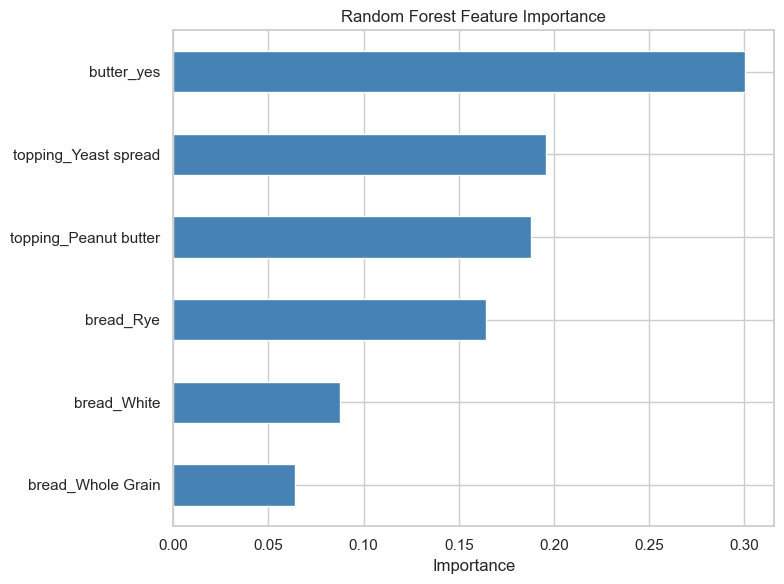

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


X = pd.get_dummies(df[['bread', 'topping', 'butter']], drop_first=True)
y = df['antCount']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)


rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
print("\nRandom Forest Regression Results:")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")


importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True)


import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
importances.plot(kind='barh', color='steelblue')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


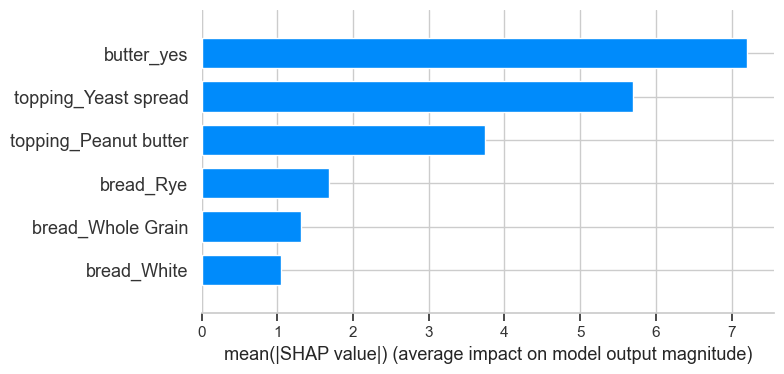

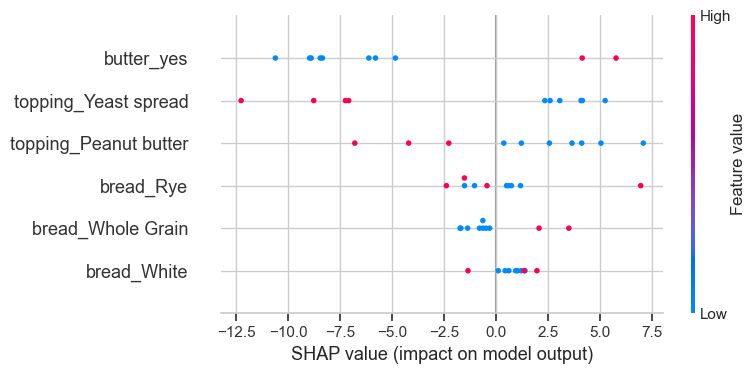

In [55]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)


shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.title("SHAP Global Feature Importance")


shap.summary_plot(shap_values, X_test)


i = 0  
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i, :])
